- import


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

- load data

In [2]:
df = pd.read_csv("CardioShieldDataSet.csv")

- data analysis

In [3]:
df=df.drop('id',axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [5]:
print(df.isnull().sum())
print(df.duplicated().sum())

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64
24


In [6]:
df.shape

(70000, 12)

In [7]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


- data preprocessing

In [8]:
# converting age into years
df['age']=df['age']/365.25
df['age']=df['age'].astype(int)

In [9]:
# taking real world range
# ap_hi (70-220)
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 220)]
# ap_lo (50-150)
df = df[(df['ap_lo'] > 50) & (df['ap_lo'] < 150)]
# removing the impossible values
df = df[df["ap_lo"] < df["ap_hi"]]

In [10]:
# height (140-210)
df = df[(df['height'] > 140) & (df['height'] < 210)]
# weight (40-200)
df = df[(df['weight'] >= 40) & (df['weight'] <= 200)]

In [11]:
# adding bmi
df['Bmi'] = round( df['weight'] / ((df['height'] / 100) ** 2) , 2)

- We engineered interaction features such as pulse pressure, age–blood pressure interaction, and glucose–BMI interaction to capture arterial stiffness and compound cardiovascular risk factors.

In [12]:
# adding other features
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['age_bp_inter'] = df['age'] * df['ap_hi']
df['gluc_bmi_inter'] = df['gluc'] * df['Bmi']


In [13]:
'''Composite risk score:
This feature combines multiple major cardiovascular risk factors
(high blood pressure, high cholesterol, smoking, and obesity)
into a single numeric score. It helps the model capture overall
risk burden instead of learning each factor separately, and reflects
real-world clinical reasoning where risk increases as more factors
are present.'''
df['composite_risk'] = (df['ap_hi']>140).astype(int) + \
                       (df['cholesterol']>1).astype(int) + \
                       (df['smoke']==1).astype(int) + \
                       (df['Bmi']>30).astype(int)

- categorizing features

In [14]:
# BMI was converted into clinically meaningful categories to reflect obesity-related cardiovascular risk.
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overwight'
    elif 30 <= bmi < 35:
        return 'Obesity class 1'
    elif 35<= bmi < 40:
        return 'Obesity class 2'
    else: 
        return 'Extreme Obesity'

df['BMI_category'] = df['Bmi'].apply(categorize_bmi)

- noise removal

In [15]:
# ---- Noise conditions for cardio = 0 ---- #

cond_old = (df['age'] >= 70)
cond_high_bp = (df['ap_hi'] >= 160) & (df['ap_lo'] >= 100)
cond_obese = (df['Bmi'] >= 35)
cond_bad_metabolic = (df['cholesterol'] == 3) & (df['gluc'] == 3)
cond_impossible_bp = (df['ap_lo'] >= df['ap_hi'])

noise_mask_0 = (df['cardio'] == 0) & (
    cond_old |
    cond_high_bp |
    cond_obese |
    cond_bad_metabolic |
    cond_impossible_bp
)

# ---- Noise conditions for cardio = 1 ---- #

cond_young = (df['age'] < 30)
cond_normal_bp = (df['ap_hi'] < 120) & (df['ap_lo'] < 80)
cond_underweight = (df['Bmi'] < 18.5)
cond_normal_metabolic = (df['cholesterol'] == 1) & (df['gluc'] == 1)

noise_mask_1 = (df['cardio'] == 1) & (
    cond_young |
    cond_normal_bp |
    cond_underweight |
    cond_normal_metabolic |
    cond_impossible_bp
)

# ---- Combine both ---- #
noise_mask = noise_mask_0 | noise_mask_1

# Remove them
df_clean = df[~noise_mask].reset_index(drop=True)

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)

# Replace original df
df = df_clean

Original shape: (68325, 18)
Cleaned shape: (43956, 18)


- data visualization

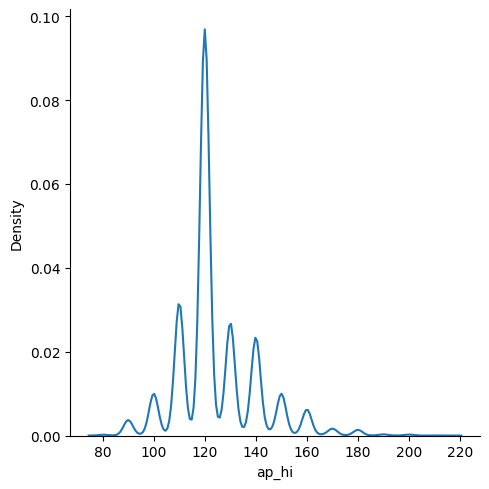

In [16]:
sns.displot(df['ap_hi'],kind='kde')

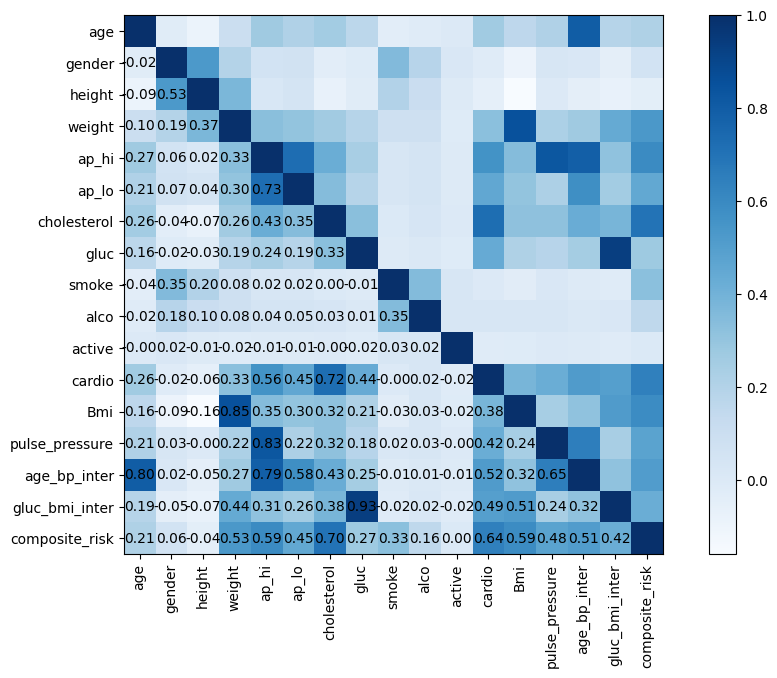

In [17]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 7))
plt.imshow(corr, cmap='Blues')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

for i in range(len(corr)):
    for j in range(len(corr)):
        if not mask[i, j]:
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

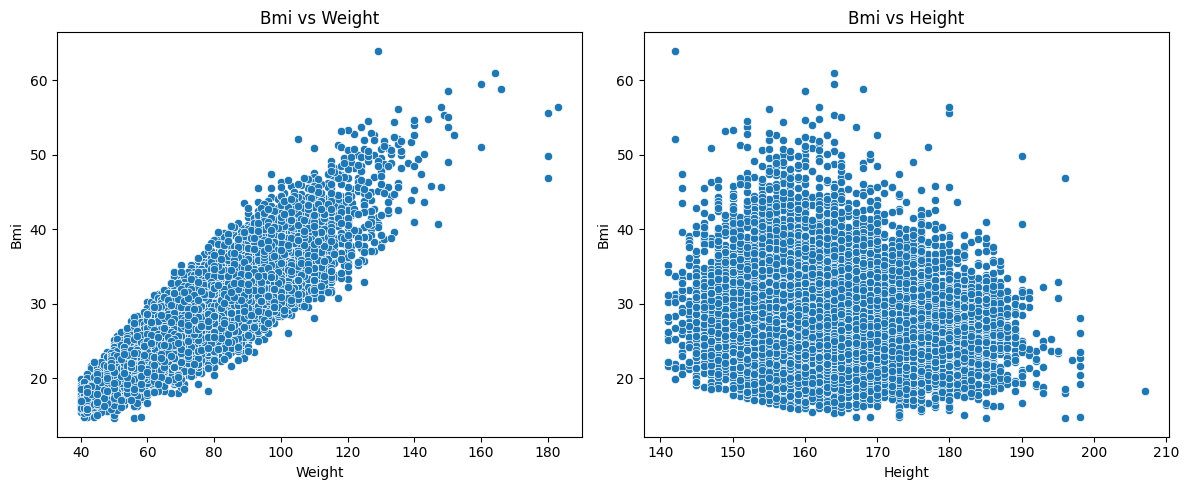

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='weight', y='Bmi', data=df)
plt.title('Bmi vs Weight')
plt.xlabel('Weight')
plt.ylabel('Bmi')
plt.subplot(1, 2, 2)
sns.scatterplot(x='height', y='Bmi', data=df)
plt.title('Bmi vs Height')
plt.xlabel('Height')
plt.ylabel('Bmi')


plt.tight_layout()
plt.show()

Text(0, 0.5, 'Diastolic Blood Pressure (ap_lo)')

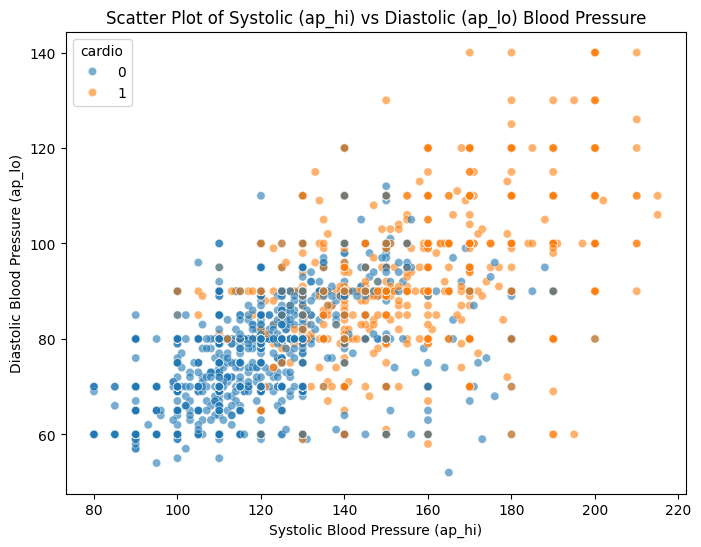

In [19]:
plt.figure(figsize=(8,6)) 
sns.scatterplot(x="ap_hi", y="ap_lo", data=df,  alpha=0.6,hue=df['cardio'])

plt.title("Scatter Plot of Systolic (ap_hi) vs Diastolic (ap_lo) Blood Pressure")
plt.xlabel("Systolic Blood Pressure (ap_hi)")
plt.ylabel("Diastolic Blood Pressure (ap_lo)")

C:\Users\win 10\AppData\Local\Temp\ipykernel_18416\53249180.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(x="BMI_category", hue="cardio", data=df, palette=["#F1DEC6" , "#FFD7C4","#FFDBB5"],edgecolor="black"


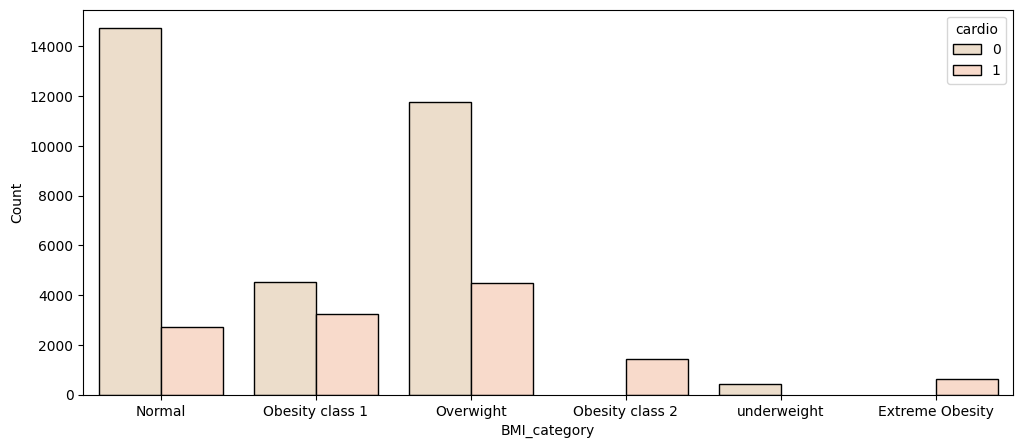

In [20]:
plt.figure(figsize=(12,5))  
sns.countplot(x="BMI_category", hue="cardio", data=df, palette=["#F1DEC6" , "#FFD7C4","#FFDBB5"],edgecolor="black"
)

plt.xlabel("BMI_category")
plt.ylabel("Count")


plt.show()

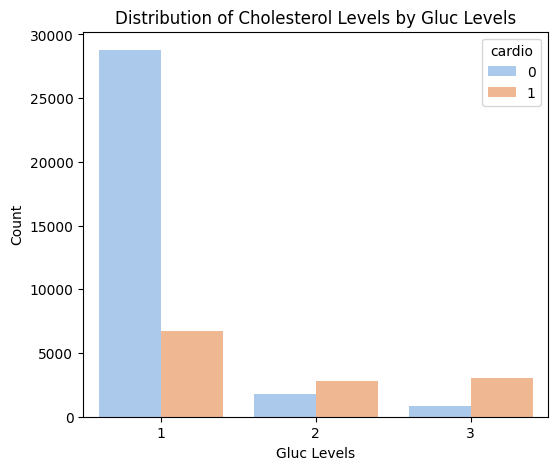

In [21]:
plt.figure(figsize=(6,5))  
sns.countplot(x="gluc", hue="cardio", data=df, palette="pastel")

plt.title("Distribution of Cholesterol Levels by Gluc Levels")
plt.xlabel("Gluc Levels")
plt.ylabel("Count")


plt.show()

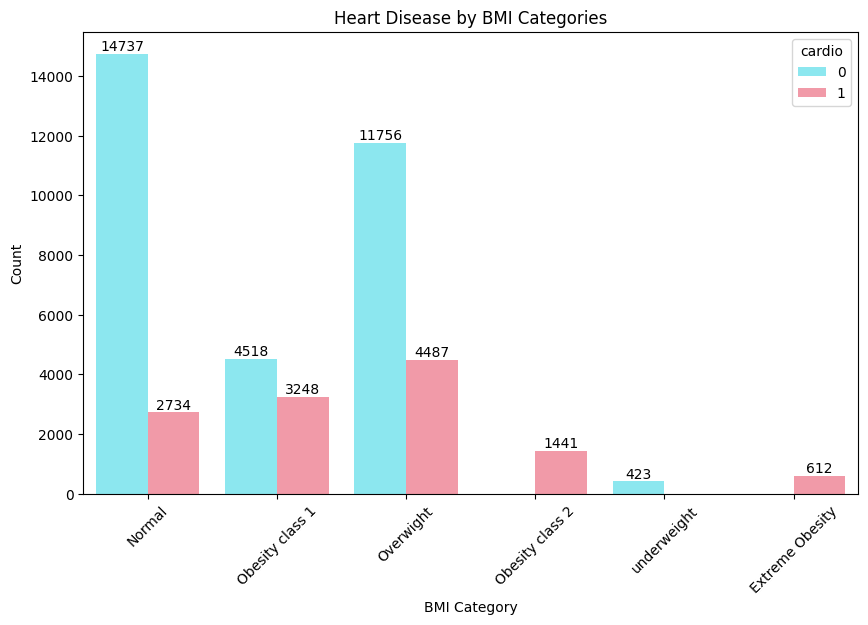

In [22]:
plt.figure(figsize=(10,6))
axis=sns.countplot(data=df, x='BMI_category', hue='cardio', palette=["#7CF5FF" ,"#FF8C9E"])
axis.bar_label(axis.containers[0])
axis.bar_label(axis.containers[1])
plt.title('Heart Disease by BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [23]:
df.to_csv('cleaned_cardio_data.csv', index=False)